Class Distribution:
 Class
0.0    7947
1.0      25
Name: count, dtype: int64


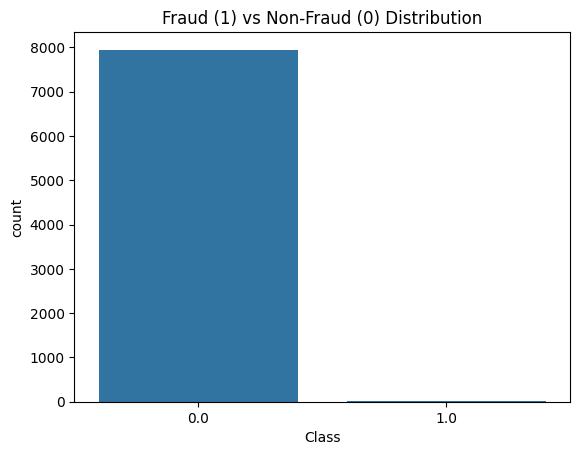

After SMOTE: [5563 5563]


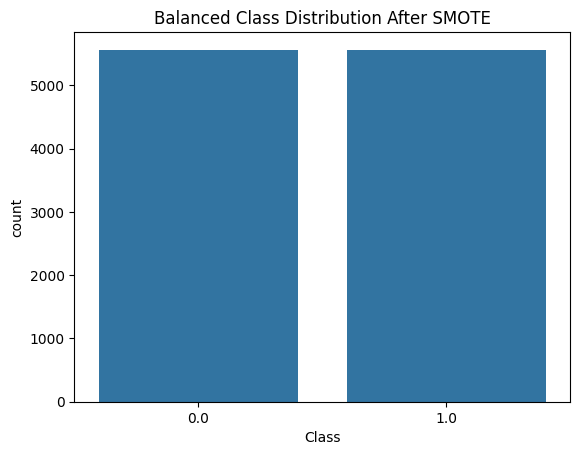

Classification Report:

              precision    recall  f1-score   support

         0.0     0.9992    1.0000    0.9996      2384
         1.0     1.0000    0.7500    0.8571         8

    accuracy                         0.9992      2392
   macro avg     0.9996    0.8750    0.9284      2392
weighted avg     0.9992    0.9992    0.9991      2392

ROC-AUC Score: 1.0


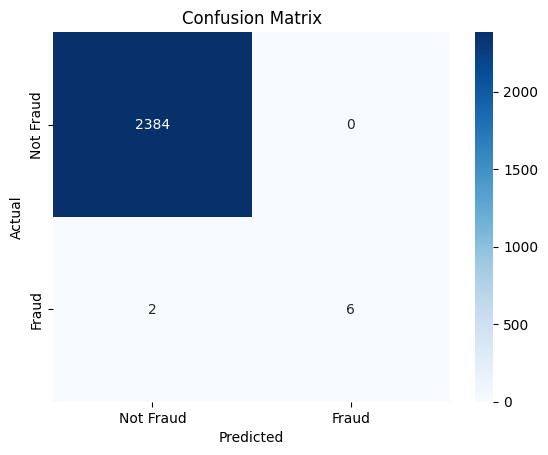

Number of frauds detected: 6
Correct frauds detected (True Positives): 6
Real-Time Transaction Prediction:
Predicted Class: NOT FRAUD
Fraud Probability Score: 0.0000


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/creditcard.csv")

# Drop rows with missing values in the 'Class' column
df.dropna(subset=['Class'], inplace=True)

df.head()

print("Class Distribution:\n", df['Class'].value_counts())
sns.countplot(data=df, x='Class')
plt.title("Fraud (1) vs Non-Fraud (0) Distribution")
plt.show()

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_res))
sns.countplot(x=y_train_res)
plt.title("Balanced Class Distribution After SMOTE")
plt.show()

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
X_test_with_preds = X_test.copy()
X_test_with_preds['Actual'] = y_test
X_test_with_preds['Predicted'] = y_pred
X_test_with_preds['Fraud_Probability'] = y_prob

# Show transactions predicted as fraud
fraud_predictions = X_test_with_preds[X_test_with_preds['Predicted'] == 1]
print(f"Number of frauds detected: {len(fraud_predictions)}")
fraud_predictions.head(10)  # Show top 10 predicted frauds
# Only correctly predicted frauds
true_positives = fraud_predictions[fraud_predictions['Actual'] == 1]
print(f"Correct frauds detected (True Positives): {len(true_positives)}")
true_positives.head()

new_transaction = pd.DataFrame([[
    -1.3598, -0.0728, 2.5363, 1.3781, -0.3383,
    0.4624, 0.2396, 0.0987, 0.3638, 0.0908,
    -0.5516, -0.6178, -0.9914, -0.3112, 1.4681,
    -0.4704, 0.2079, 0.0257, 0.4030, 0.2514,
    -0.0183, 0.2778, -0.1105, 0.0669, 0.1285,
    -0.1891, 0.1335, -0.0210, 10000.00, 120.35  # 'Time', 'Amount'
]], columns=X.columns)

# Predict fraud (0 or 1)
predicted_class = model.predict(new_transaction)[0]
predicted_prob = model.predict_proba(new_transaction)[0][1]

print("Real-Time Transaction Prediction:")
print(f"Predicted Class: {'FRAUD' if predicted_class == 1 else 'NOT FRAUD'}")
print(f"Fraud Probability Score: {predicted_prob:.4f}")
